# Tequila Chemistry Basics

Here we show the basics of the tequila chemistry module.  

- Initialization of molecules within tequila
- Usage of different qubit encodings from openermion (JW, BK, BKSF, Tapered-BK)
- Using basic functionality of Psi4 with tequila
- Setting up active spaces
- Constructing UCC based quantum circuits with tequila

We recommend also to take a look at:  
- [arxiv:2011.03057](https://arxiv.org/abs/2011.03057) that gives a general overview over `tequila` including chemistry applications
- [arxiv:2011.05938](https://arxiv.org/abs/2011.05938) that describes the automatically differentiab.le framework for unitary coupled-cluster. This framework is automatically applied for all gates that are constructed with `mol.make_excitation_gate` function. 

In order for this notebook to work properly, you need to have psi4 installed in the same python environment as tequila.  
If you are in a conda environment, installing psi4 is easy:
`conda install psi4 -c psi4`  
But better also check the [psi4 website](http://www.psicode.org/) for up to date instructions.

In some cases, problems with the environment were observed which are suspected to originate from conflicts between psi4 and tequila dependcies.  
Usually the safest way is to install psi4 **first** and then install tequila.    

Basic functionality is currently also provided with PySCF which might be easier to install. 

`tequila` also supports `madness` as a quantum chemistry backend. With `madness` it is possible to construct system adapted Hamiltonians in a basis-set-free representation. It offers some extended features, but everything else (creating UCC circuits, fermion-to-qubit encodings, etc) stays roughly the same. For more information, see [arxiv:2008.02819](https://arxiv.org/abs/2008.02819) and the separate [tutorial](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/ChemistryMadnessInterface.ipynb).  

At the moment we only support automatized handling of closed-shell molecules. Note however, that this only concerns the computation of molecular orbitals; 
In other words: Only closed-shell references can be handeled automatically.

**There might be issues with psi4 and jupyter, currently the workarround is to reload the kernel before a cell gets executed, or run as a regular python script**  
(issue seems to be resolved, leaving this warning in, just in case)As alwasy: If you should experience any trouble, please raise an issue on github or contact us directly

One of `tequila`s primary aims is to simplify usage of many specialized algorithms and programs. The underlying technology should however be acknowledged, so if you are using the interface please acknowledge/cite the following articles (we give arxiv links to provide open access to the articles, but please cite the scientific journals if the articles have been published there):

- [arxiv:2011.03057](https://arxiv.org/abs/2011.03057) giving the general overview of tequila.
- [arxiv:2011.05938](https://arxiv.org/abs/2011.05938) describing the automatically differentiable framework for unitary coupled-cluster (those techniques are automatically applied in the background). 
- [OpenFermion](https://github.com/quantumlib/OpenFermion) that handles the standard fermion-to-qubit mappings.
- Please also cite the corresponding articles of the quantum simulators (if not specified, this is usually [qulacs](https://github.com/qulacs/qulacs)) and optimizers that you are using within  `tequila` and the corresponding quantum chemistry backends (like [Psi4](https://github.com/psi4/psi4), [madness](https://github.com/m-a-d-n-e-s-s/madness) or [PySCF](https://github.com/pyscf)). 

In [1]:
# needs version >= 1.5 for full functionality
# see very last cell for some info on troubleshooting
import tequila as tq

## Initialize Molecules

Molecules can be initialized by passing their geometries as string or the name of a `xyz` file.  
So instead of the example in the code cell below, you could also specify `geometry=lih.xyz` and provide a file `lih.xyz` that gives the LiH coordinates in [xyz](https://en.wikipedia.org/wiki/XYZ_file_format) format. As it is often conventional in quantum chemistry, molecular coordinates are expected in Ångstrom units while all other quantities (energies) will be in atomic units (Hartree).  
You can print out the `Molecule` object to receive more information.

In [2]:
import tequila as tq
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g")
print(molecule)

<class 'tequila.quantumchemistry.psi4_interface.QuantumChemistryPsi4'>
Qubit Encoding
JordanWigner

Parameters
basis_set       : sto-3g          
geometry        : H 0.0 0.0 0.0
Li 0.0 0.0 1.6 
description     :                 
multiplicity    : 1               
charge          : 0               
name            : lih             

Psi4 Data
Point Group (full) : c_inf_v         
Point Group (used) : c2v             
nirrep          : 4 
irreps          : ['A1', 'A2', 'B1', 'B2'] 
mos per irrep   : [4, 0, 1, 1]    

Orbitals:
0 : 0A1 energy = -2.348839 
1 : 1A1 energy = -0.285276 
2 : 2A1 energy = +0.078216 
3 : 0B1 energy = +0.163950 
4 : 0B2 energy = +0.163950 
5 : 3A1 energy = +0.547769 



### Molecular Orbitals and Point-Groups
As seen in the above printout, the (spatial) molecular orbitals are labelled by their irreducible representations. 
If you are not familiar with discrete point-groups: Just ignore that information. It is not needed in any of our functions, but you might want to use that information for your own algorithms.  

The full point-group of the linear LiH molecule is $C_{{\infty}v}$, `Psi4` can however only handle abelian point-groups and resorts to the largest abelian subgroup, that is in this case $C_{2v}$. 

In case you want to change the point-group you can do so by providing the `Molecule` initialization with the keyword: `point_group='POINT_GROUP_NAME'`.  

The `mol.orbitals` array carries all information about the orbitals (energies are in this case the Hartree-Fock orbital energies).  

In [3]:
molecule.orbitals[3]

QuantumChemistryPsi4.OrbitalData(irrep='B1', idx_irrep=0, idx_total=3, energy=0.16394999244955274)

### Initialize Qubit-Hamiltonians

You can initialize a tequila `QubitHamiltonian` from a molecule with `make_hamiltonian`.
The standard transformation is the `jordan-wigner` transformation.  
You can use other transformations by initializing the molecule with the `transformation` keyword.

In [4]:
import tequila as tq
H = molecule.make_hamiltonian()
# the LiH Hamiltonian is already quite large, better not print the full thing
print("Hamiltonian has {} terms".format(len(H)))
print("Hamiltonian has {} qubits".format(H.n_qubits))

Hamiltonian has 631 terms
Hamiltonian has 12 qubits


Here are some examples where we initialize the `Molecule` with different transformation keywords.  

In [5]:
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", transformation="BravyiKitaev")
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))
print("Hamiltonian has {} qubits".format(H.n_qubits))

Hamiltonian has 631 terms
Hamiltonian has 12 qubits


In [6]:
# symmetry_conserving_bravyi_kitaev in older tequila versions
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", transformation="TaperedBravyiKitaev")
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))
print("Hamiltonian has {} qubits".format(H.n_qubits))

Hamiltonian has 631 terms
Hamiltonian has 10 qubits


## Using different Qubit Encodings of OpenFermion

The different qubit encodings of openfermion can be applied by passing the keyword `transformation` to the molecule and setting it to the name of the corresponding openfermion function.  

Some of those transformation might require additional keywords. Following `psi4` conventions those should be given to the `Molecule` initialization with the prefix `transformation__`. For most of them, `tequila` is however able to assign the keys automatically (see above for the `TaperedBravyiKitaev` transformation, that tapers off two qubits.

In the following we provide some examples using various transformations from openfermion

In [7]:
import tequila as tq
import numpy
geomstring = "H 0.0 0.0 0.0\nH 0.0 0.0 0.7"
basis_set = "sto-3g"

# Jordan-Wigner (this is the default)
mol = tq.chemistry.Molecule(geometry=geomstring, basis_set=basis_set, transformation="jordan_wigner")
H = mol.make_hamiltonian()
print("Jordan-Wigner\n", H)
eigenValues = numpy.linalg.eigvalsh(H.to_matrix())
print("lowest energy = ", eigenValues[0])

# Bravyi-Kitaev
mol = tq.chemistry.Molecule(geometry=geomstring, basis_set=basis_set, transformation="bravyi_kitaev")
H = mol.make_hamiltonian()
print("Bravyi-Kitaev\n", H)
eigenValues = numpy.linalg.eigvalsh(H.to_matrix())
print("lowest energy = ", eigenValues[0])

# symmetry_conserving_bravyi_kitaev in old versions
# this transformation will taper off two qubits of the Hamiltonian
# it needs additional information on the number of spin-orbitals and the active_fermions/electrons in the system
mol = tq.chemistry.Molecule(geometry=geomstring, basis_set=basis_set,
                              transformation="TaperedBravyiKitaev")
H = mol.make_hamiltonian()
print("TaperedBravyiKitaev\n", H)
eigenValues = numpy.linalg.eigvalsh(H.to_matrix())
print("lowest energy = ", eigenValues[0])

# Symmetry 

Jordan-Wigner
 -0.0421+0.1777Z(0)+0.1777Z(1)-0.2427Z(2)-0.2427Z(3)+0.1706Z(0)Z(1)+0.0448Y(0)X(1)X(2)Y(3)-0.0448Y(0)Y(1)X(2)X(3)-0.0448X(0)X(1)Y(2)Y(3)+0.0448X(0)Y(1)Y(2)X(3)+0.1229Z(0)Z(2)+0.1677Z(0)Z(3)+0.1677Z(1)Z(2)+0.1229Z(1)Z(3)+0.1763Z(2)Z(3)
lowest energy =  -1.1361894540879058
Bravyi-Kitaev
 -0.0421+0.1777Z(0)+0.1777Z(0)Z(1)-0.2427Z(2)-0.2427Z(1)Z(2)Z(3)+0.1706Z(1)+0.0448Y(0)Z(1)Y(2)Z(3)+0.0448X(0)Z(1)X(2)+0.0448X(0)Z(1)X(2)Z(3)+0.0448Y(0)Z(1)Y(2)+0.1229Z(0)Z(2)+0.1677Z(0)Z(1)Z(2)Z(3)+0.1677Z(0)Z(1)Z(2)+0.1229Z(0)Z(2)Z(3)+0.1763Z(1)Z(3)
lowest energy =  -1.1361894540879065
TaperedBravyiKitaev
 -0.2879+0.4205Z(0)+0.4205Z(1)+0.0115Z(0)Z(1)+0.1790X(0)X(1)
lowest energy =  -1.1361894540879058


## Setting active spaces

You can define active spaces on your molcule by passing down a dictionary of active orbitals.  
The orbitals are grouped into the irreducible representation of the underlying symmetry group (see the printout of `print(molecule)` above).

Lets take the LiH molecule from above but initialize it with an active space containing the second two A1 orbitals (meaning the first 0A1 orbital is frozen) and the B1 orbital

In [8]:
import tequila as tq
active_orbitals = {"A1":[1,2], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 62 terms


Lets make the active space even smaller, so that we can print out the full Hamiltonian

In [9]:
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))
print(H)

Hamiltonian has 15 terms
-7.4711+0.1352Z(0)+0.1352Z(1)-0.0310Z(2)-0.0310Z(3)+0.1218Z(0)Z(1)+0.0059Y(0)X(1)X(2)Y(3)-0.0059Y(0)Y(1)X(2)X(3)-0.0059X(0)X(1)Y(2)Y(3)+0.0059X(0)Y(1)Y(2)X(3)+0.0617Z(0)Z(2)+0.0675Z(0)Z(3)+0.0675Z(1)Z(2)+0.0617Z(1)Z(3)+0.0782Z(2)Z(3)


## Computing classical methods with Psi4

We can use psi4 to compute the energies (and sometimes other quantities) with the `compute_energy` function.
Here are some examples. Note that the energies are computed within the active space if one is set.

Note also that not all active spaces can be represented by psi4 which will mean you can/should not use the classical psi4 methods with those (a warning will be printed). You will still get the right active space hamiltonian however.

Active spaces which will not work for psi4 methds are the ones where the orbitals of individual irreps are not in one block ( e.g. {`"A1":[1,3]`} )

In [10]:
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0], "B2":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

mp2 = molecule.compute_energy(method="mp2")

# Note there are known issues for some methods when the active space as frozen virtuals as is the case here
# detci based methods are fine again 
fci = molecule.compute_energy(method="fci")

# for most coupled-cluster like models you can compute amplitudes
# Amplitudes are computed in c1 and in the full space, this is why the active space troubles from above usually don't hold
# Note that amplitudes are in closed-shell
amplitudes = molecule.compute_amplitudes("mp2")

# you can export a parameter dictionary which holds the indices of the amplitude as keys and values as values
# for this small active space that is only one amplitude for mp2
variables = amplitudes.make_parameter_dictionary()
print(variables)

# similar for ccsd since the singles are 0 due to symmetry (that changes if you change the active space)
amplitudes = molecule.compute_amplitudes("ccsd")
variables = amplitudes.make_parameter_dictionary()
print(variables)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for mp2.
{(1, 0, 1, 0): -0.02606939610862482, (2, 0, 2, 0): -0.02606939610862415}
{(1, 0, 1, 0): -0.027418022892187574, (2, 0, 2, 0): -0.02741802289218757}


## Hello World "H2" optimization with LiH in an active space

Lets do a small hand-constructed VQE like it would be done for the Hydrogen molecule in STO-3G, just that we use our active space LiH molecule from the cell above.
For consistency reasons we initialize everything again.  

Check the `BasicUsage` and `SciPyOptimizers` tutorial notebooks for more information about then

In [11]:
import tequila as tq
# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# define a hand designed circuit
U = tq.gates.Ry(angle="a", target=0) + tq.gates.X(target=[2,3])
U += tq.gates.X(target=1, control=0)
U += tq.gates.X(target=2, control=0)
U += tq.gates.X(target=3, control=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))


Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=-7.19702401  angles= {a: 0.0}  samples= None
E=-7.19766373  angles= {a: -0.0234220027923584}  samples= None
E=-7.20203763  angles= {a: -0.11711001396179199}  samples= None
E=-7.24749228  angles= {a: -0.49186205863952637}  samples= None
E=-7.68640044  angles= {a: -1.9908702373504639}  samples= None
E=-7.59671569  angles= {a: -7.986902952194214}  samples= None
E=-7.86212174  angles= {a: -3.1296004573497562}  samples= None
E=-7.59889693  angles= {a: -1.7104055550401813}  samples= None
E=-7.86268191  angles= {a: -3.077723763670849}  samples= None
E=-7.86268890  angles= {a: -3.0712456200257225}  samples= None
Optimization terminated successfully.
         Current function value: -7.

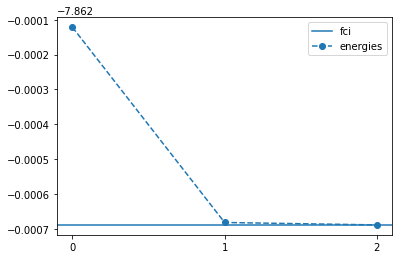

In [12]:
# some more information from the optimization
result.history.plot("energies", baselines={"fci":fci})

## Unitary Coupled-Cluster Style Construction

Here we show how to initialize in the style of unitary coupled-cluster.  
See also the overview article [arxiv.org/abs/2011.03057](https://arxiv.org/abs/2011.03057) for more details about the underlying methods.

In the next example we are gonna compute the `mp2` amplitudes and build a UCC type circuit from them.  
Here we use the cc2 amplitudes only to define an order on the trotterized gates and remove small amplitudes as classical prescreening.

We use again an active space to make the computation fast.

First we start with the manual construction and then show how to use in build convenience functions of tequila to.

An important function is the `make_excitation_generator` function of the molecule.  
This initializes a `QubitHamiltonian` which can be used to define a unitary gate which acts as excitation operation of electrons.

$$\displaystyle
U(\theta) = e^{-i\frac{\theta}{2} G_{iajbkc\dots}}
$$

In fermionic language the generator is defined as

$$
G_{ia,jb,jc,\dots} =  i ( a^\dagger_a a_i a^\dagger_b a_j a^\dagger_c a_k \dots - h.c. )
$$

The `make_excitation_generator` function gives back this generator in the qubit representation (depends on the chosen `transformation` of the molecule) and takes the indices as list of tuples  
  
$$
\texttt{make_excitation_generator(indices=[(a,i),(b,j),...])} \longrightarrow G_{ia,jb,jc,\dots}
$$

You can use those generators to initialize \textit{formally} Trotterized Gates (one step is exact):  
$$
\texttt{tq.gates.Trotterized(generators=[generator], angles=["a"], steps=1)} \longrightarrow U(\theta) = e^{-i\frac{\theta}{2} G_{iajbkc\dots}}
$$

The last part was the general construction of gates over their parameters. In the case of Unitary coupled-cluster you can define fermionic gates directly, \textsc{tequila} will then be able to compute analytical gradients with substantially reduced cost (see this article for an in-depth description: [arxiv.org/abs/2011.05938](https://arxiv.org/abs/2011.05938)). The fermionic gate is initialized over the same list of index-tuples that initialize generators:

$$
\texttt{make_excitation_gate(indices=[(a,i),(b,j),...])} \longrightarrow U(\theta) = e^{-i\frac{\theta}{2} G_{iajbkc\dots}}
$$

Angles can be either numeric types (such as 1.0, 1.5, numpy.pi/2) for fixed angles, any hashable type (such as "a", "xyz", (1,2,3) ) for variables, or a tequila objective for variable dependent transformations (see also the BasicUsage tutorial here). 


### Manual Construction

In [13]:
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
# make the hamiltonian
H = molecule.make_hamiltonian()

# compute classical amplitudes
amplitudes = molecule.compute_amplitudes(method="mp2")

# in this example there is only one closed-shell MP2 amplitude, therefore manual construction is reasonable in this tutorial
# first we make a dictionary out of the non-zero MP2 amplitudes
ampdict = amplitudes.make_parameter_dictionary(threshold=threshold)
print("MP2 Amplitudes:\n", ampdict)
# lets get the indices of the only amplitude which is there manually
indices = list(ampdict.keys())[0]

# the (1, 0, 1, 0) index in closed shell leads to the (2, 0, 3, 1) and (3, 1, 2, 0) excitations on the qubits
# but first we need to initialize the hartree fock state
U = molecule.prepare_reference()

# UCC excitation gates can be directly initialized as follows:
# This will lead to significantly reduced cost in gradient evaluation (see text cell above)
# We also illustrate here how to define transformed angles by scaling the angle with 2.0
# (this makes it comarable to the MP2 amplitude, since it cancels out the conventional factor of 1/2 in the definition of the gates)
a = tq.Variable("a")
U += molecule.make_excitation_gate(indices=[(3, 1),(2, 0)], angle=2.0*a)

print("This is our circuit:")
print(U)

# lets form the expectation value
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.01 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")
print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))
print("MP2 Amplitudes:", ampdict) # indices in spatial orbital notation
print("Optimized UCC Amplitudes:", result.variables) # indices in spin-orbital notation



MP2 Amplitudes:
 {(1, 0, 1, 0): -0.02606939610862482}
This is our circuit:
circuit: 
X(target=(0,))
X(target=(1,))
FermionicExcitation(target=(0, 1, 2, 3), control=(), parameter=f([a]))

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=-7.86132988  angles= {a: 0.01}  samples= None
E=-7.86253976  angles= {a: -0.05013059616088867}  samples= None
E=-7.86268890  angles= {a: -0.03515792946196591}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
VQE : -7.8626889f
FCI : -7.8626889f
MP2 Amplitudes: {(1, 0, 1, 0): -0.02606939610862482}
Optimized UCC Amplitudes: a : -0.03515792946196591



### Automatic Construction

In [14]:
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# make the UCCSD ansatz (note that this will be without singles since it starts from mp2)
U = molecule.make_uccsd_ansatz(initial_amplitudes="mp2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))
    
    

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 6 expectationvalues

active variables : 2

E=-7.86186477  angles= {(1, 0, 1, 0): 0.0, ((0, 1), 'S', None): 0.0}  samples= None
E=-7.86259809  angles= {(1, 0, 1, 0): -0.0468440055847168, ((0, 1), 'S', None): 0.0}  samples= None
E=-7.86268890  angles= {(1, 0, 1, 0): -0.03516504106977361, ((0, 1), 'S', None): 0.0}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
VQE : -7.8626889f
FCI : -7.8626889f


### Pi System of Benzene
Here is the \pi-system of Benzene, computed with the [UpCCGSD](https://pubs.acs.org/doi/10.1021/acs.jctc.8b01004) ansatz. The fermionic gradient techniques from [arxiv.org/abs/2011.05938](https://arxiv.org/abs/2011.05938) allow us to compute analytical gradients with a cost factor of 2 (this is the same cost as the cheapest 2-point numerical stencils). We neglect the singles here to speed-up the computation - so essentially this is UpCCGD. You can also create different k-UpCCGSD circuits by changing `name=UpCCGD` (e.g. `name="UpCCGSD"` `name="2-UpCCD"` etc). You can also try to build a batched optimization by re-using results from previous optimizations (get the optimized variables over `result.variables`)

In [15]:
import tequila as tq
threshold = 1.e-6
active = {"B1u": [0], "B3g": [0, 1], "B2g": [0], "Au": [0], "b1u": [1]}
molecule = tq.quantumchemistry.Molecule(geometry="data/benzene.xyz", basis_set='sto-3g', active_orbitals=active)
H = molecule.make_hamiltonian()

U = molecule.make_upccgsd_ansatz(name="UpCCGD")

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# compute reference energies
mp2 = molecule.compute_energy("mp2")
cisd = molecule.compute_energy("detci", options={"detci__ex_level": 2})
fci = molecule.compute_energy("fci")

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values=0.0)

print("VQE : {:+2.8}f".format(result.energy))
print("MP2 : {:+2.8}f".format(mp2))
print("CISD: {:+2.8}f".format(cisd))
print("FCI : {:+2.8}f".format(fci))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for mp2.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 30 expectationvalues

active variables : 15

E=-227.88792153  angles= {(((0, 1),), 'D', (None, 0)): 0.0, (((0, 2),), 'D', (None, 0)): 0.0, (((0, 3),), 'D', (None, 0)): 0.0, (((0, 4),), 'D', (None, 0)): 0.0, (((0, 5),), 'D', (None, 0)): 0.0, (((1, 2),), 'D', (None, 0)): 0.0, (((1, 3),), 'D', (None, 0)): 0.0, (((1, 4),), 'D', (None, 0)): 0.0, (((1, 5),), 'D', (None, 0)): 0.0, (((2, 3),), 'D', (None, 0)): 0.0, (((2, 4),), 'D', (None, 0)): 0.0, (((2, 5),), 'D', (None, 0)): 0.0, (((3, 4),), 'D', (None, 0)): 0.0, (((3, 5),), 'D', (None, 0)): 0.0, (((4, 5),), 'D', (None, 0)): 0.0}  samples= None
E=-227.91711515  angle

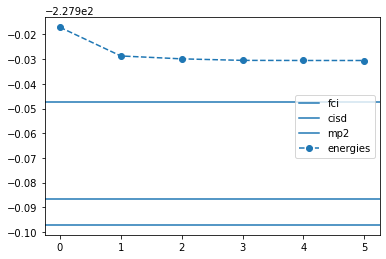

In [16]:
result.history.plot("energies", baselines={"fci":fci, "cisd": cisd, "mp2":mp2}, filename="benzene_result_bfgs")

## Noisy optimization of an active space molecule with tapered qubit embeding using `qiskit` as quantum backend

This example shows the combination of several features of tequila in a few lines.  
Note that you will need to have `qiskit` installed for this.  
If not: Set `backend=None` (`tequila` will then pick whatever backend you have installed that is most appropriate for the job) and set `device=None` (there will be no specialized noise emulation in that case, see our tutorial on noise model on how to construct your own!)

- automatic handling of active spaces
- consitent usage of qubit encodings (here the TaperedBravyiKitaev encoding from openfermion which reduces the number of qubits by 2)
- custom circuit construction
- unitary cluster circuits
- optimization of measurements (here the Hamiltonian will be grouped into two commuting groups, this can be seen by the optimizer output which holds two expectation values). See the [MeasurementGroups](https://github.com/aspuru-guzik-group/tequila/blob/master/tutorials/MeasurementGroups.ipynb) tutorial for more background information.
- interface to different quantum backends (you will need qiskit to run this cell)

In [17]:
import tequila as tq
# define the active space
active_orbitals = {"A1":[1], "B1":[0]}
samples = 10000
if 'qiskit' in tq.INSTALLED_SIMULATORS:
    backend = "qiskit"
    device = "fake_valencia"
else:
    backend = None
    device = None

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6",
                                 basis_set="sto-3g",
                                 active_orbitals=active_orbitals,
                                 transformation="TaperedBravyiKitaev")

fci = molecule.compute_energy("fci")

H = molecule.make_hamiltonian()

# Toy circuit (no deeper meaning)
U = tq.gates.Ry(angle="a", target=0)
U += tq.gates.X(target=1, control=0)
E = tq.ExpectationValue(H=H, U=U, optimize_measurements=True)

vqe = tq.minimize(method="cobyla", objective=E, initial_values=0.0)
noisy_vqe = tq.minimize(method="cobyla", objective=E, samples=samples, backend=backend, device=device, initial_values=0.0)
 
# The same with UpCCSD and standard BK (Tapered encodings not supported yet for UCC generators ... )
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6",
                                 basis_set="sto-3g",
                                 active_orbitals=active_orbitals,
                                 transformation="BravyiKitaev")
H = molecule.make_hamiltonian()
UpCCGSD = molecule.make_upccgsd_ansatz(name="UpCCSD")
E2 = tq.ExpectationValue(H=H, U=UpCCGSD, optimize_measurements=True)
ucc = tq.minimize(method="cobyla", objective=E2, initial_values=0.0)
noisy_ucc = tq.minimize(method="cobyla", objective=E2, samples=samples,  backend=backend, device=device, initial_values=0.0)

# The same in hardcore-boson approximation (see https://arxiv.org/abs/2105.03836 for details on the implementation
# and the SeparablePairAnsatz notebook for more advanced approaches in this direction)
HCBH = molecule.make_hardcore_boson_hamiltonian()
UpCCD = molecule.make_upccgsd_ansatz(name="HCB-UpCCD")
E3 = tq.ExpectationValue(H=HCBH, U=UpCCD, optimize_measurements=True)
ucc2 = tq.minimize(method="cobyla", objective=E3, initial_values=0.0)
noisy_ucc2 = tq.minimize(method="cobyla", objective=E3, samples=samples,  backend=backend, device=device, initial_values=0.0)

print("VQE             = {:2.8f}".format(min(vqe.history.energies)))
print("VQE (noisy)     = {:2.8f}".format(min(noisy_vqe.history.energies)))
print("UCC             = {:2.8f}".format(min(ucc.history.energies)))
print("UCC (noisy)     = {:2.8f}".format(min(noisy_ucc.history.energies)))
print("HCB-UCC         = {:2.8f}".format(min(ucc2.history.energies)))
print("HCB-UCC (noisy) = {:2.8f}".format(min(noisy_ucc2.history.energies)))

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 2 expectationvalues

active variables : 1

E=-7.19702387  angles= {a: 0.0}  samples= None
E=-7.33012819  angles= {a: 1.0}  samples= None
E=-7.64648247  angles= {a: 2.0}  samples= None
E=-7.85523319  angles= {a: 3.0}  samples= None
E=-7.76445484  angles= {a: 4.0}  samples= None
E=-7.84895802  angles= {a: 3.5}  samples= None
E=-7.82776165  angles= {a: 2.75}  samples= None
E=-7.86143017  angles= {a: 3.125}  samples= None
E=-7.86244774  angles= {a: 3.25}  samples= None
E=-7.85826778  angles= {a: 3.375}  samples= None
E=-7.86100483  angles= {a: 3.3125}  samples= None
E=-7.86268139  angles= {a: 3.21875}  samples= None
E=-7.86258984  angles= {a: 3.1875}  samples= None
E=-7.86267614  angles= {a: 3.203125}  samples= None
E=-7.86265326  angles= {a: 3.2265625}  sample

E=-7.85562658  angles= {(((0, 1),), 'D', (None, 0)): 0.06920357832039338, ((0, 1), 'S', (None, 0)): 0.24023085719293674}  samples= 10000
E=-7.85713291  angles= {(((0, 1),), 'D', (None, 0)): -0.11112444812878011, ((0, 1), 'S', (None, 0)): -0.057239470892680853}  samples= 10000
E=-7.86139107  angles= {(((0, 1),), 'D', (None, 0)): 0.010301359684967797, ((0, 1), 'S', (None, 0)): 0.06164521058963884}  samples= 10000
E=-7.86319590  angles= {(((0, 1),), 'D', (None, 0)): 0.05806012889033098, ((0, 1), 'S', (None, 0)): -0.02313593380951271}  samples= 10000
E=-7.86168575  angles= {(((0, 1),), 'D', (None, 0)): 0.09465786163777877, ((0, 1), 'S', (None, 0)): -0.07380008245277314}  samples= 10000
E=-7.86273098  angles= {(((0, 1),), 'D', (None, 0)): 0.07573180120332124, ((0, 1), 'S', (None, 0)): 0.002637589381201698}  samples= 10000
E=-7.86250782  angles= {(((0, 1),), 'D', (None, 0)): 0.04261906175232663, ((0, 1), 'S', (None, 0)): -0.02074552157735646}  samples= 10000
E=-7.86255121  angles= {(((0, 1),

/home/jsk/anaconda3/envs/tq-psi4-3.9/lib/python3.9/site-packages/tequila/quantumchemistry/qc_base.py:1021: TequilaWarning: Hardcore-Boson Hamiltonian without reordering will result in non-consecutive Hamiltonians that are eventually not be combinable with other features of tequila. Try transformation='ReorderedJordanWigner' or similar for more consistency
  warnings.warn(


E=-7.86167717  angles= {(((0, 1),), 'D', (None, 0)): 0.0}  samples= 10000
E=-7.68836546  angles= {(((0, 1),), 'D', (None, 0)): 1.0}  samples= 10000
E=-7.72885752  angles= {(((0, 1),), 'D', (None, 0)): -1.0}  samples= 10000
E=-7.83230019  angles= {(((0, 1),), 'D', (None, 0)): -0.5}  samples= 10000
E=-7.84517336  angles= {(((0, 1),), 'D', (None, 0)): 0.25}  samples= 10000
E=-7.86149406  angles= {(((0, 1),), 'D', (None, 0)): -0.125}  samples= 10000
E=-7.85974312  angles= {(((0, 1),), 'D', (None, 0)): 0.0625}  samples= 10000
E=-7.86256123  angles= {(((0, 1),), 'D', (None, 0)): -0.03125}  samples= 10000
E=-7.86282539  angles= {(((0, 1),), 'D', (None, 0)): -0.0625}  samples= 10000
E=-7.86284161  angles= {(((0, 1),), 'D', (None, 0)): -0.09375}  samples= 10000
E=-7.86219931  angles= {(((0, 1),), 'D', (None, 0)): -0.109375}  samples= 10000
E=-7.86250067  angles= {(((0, 1),), 'D', (None, 0)): -0.0859375}  samples= 10000
E=-7.86203623  angles= {(((0, 1),), 'D', (None, 0)): -0.09765625}  samples= 

# Last Stable run of this Notebook

Using Anaconda3 on Ubuntu and Python 3.9.  
Environment was setup like this:

```bash
conda create -n tq-env python=3.9
conda activate tq-env
conda install psi4=1.6.1 -c psi4
pip install --upgrade "tequila-basic==1.7.0"
pip install --upgrade "qulacs==0.3.0"
```